In [45]:
import pandas as pd
import numpy as np
from numpy import newaxis

import random
import itertools

import os
from os import listdir
from os.path import isfile
import math

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec

import datetime
from tqdm import *
from datetime import *

import keras
from keras.applications import *
import lightgbm as lgbm
import os
from scipy import ndimage
from scipy import misc
from scipy import signal
import cv2
plt.ion()
plt.show()

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Lambda, Layer, Conv2D, MaxPooling2D,UpSampling2D, concatenate, Dropout,Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

import shutil
import collections
from collections import *

import tensorflow as tf
from IPython.display import clear_output
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [ ]:
# !dir data/stage1_test

In [2]:
trainDir = 'data/stage1_train/'
testDir = 'data/stage1_test/'
unetSize = 128

In [3]:
fileIDs = listdir(trainDir)
testIDs = listdir(testDir)
len(testIDs)

65

In [4]:
def getFileImage(fileID, dd=trainDir):
    if not os.path.isfile(dd + fileID + '/images/'+ fileID + '.png'):
        print('Missing image file with ID %s' % fileID)
        return None
    else:
        return misc.imread(dd + fileID + '/images/'+fileID + '.png')

def drawContour(x):
    res = signal.convolve2d(x, [[1,1,1],[1,1,1],[1,1,1]], 'same')
    indices = np.where((res/255 < 9) & (x == 255)==True)
    x[indices[0],indices[1]] = 128
    return x

def getFileMasks(fileID):
    if not os.path.isdir(trainDir + fileID + '/masks/'):
        print('Missing image file with ID %s' % fileID)
        return None
    else:
        theMask = None
        for mask in listdir(trainDir + fileID + '/masks/'):
            m = misc.imread(trainDir + fileID + '/masks/' + mask)
            m = drawContour(m)
            if theMask is None:
                theMask = m
            else:
                theMask = theMask + m
        return theMask
        


In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def imgResizeNormalizeAndGrayscale(img, newDimension, normalize = True, grayscale = True):

        
    # todo: check both dimensions, or either
    if img.shape[0] > newDimension[0]: 
        img = cv2.resize(img,newDimension, cv2.INTER_AREA)
    else:
        img = cv2.resize(img,newDimension, cv2.INTER_CUBIC)
        
    if normalize :
        img = cv2.normalize(img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F, dst=None)
    # convert image to grayscale only if it has 3 dimensions - it is not already grayscale
    if grayscale and len(img.shape) > 2 and img.shape[2] >= 3:
        img = rgb2gray(img)
    return img
    
# evaluateImage(40)

(256, 320, 4)


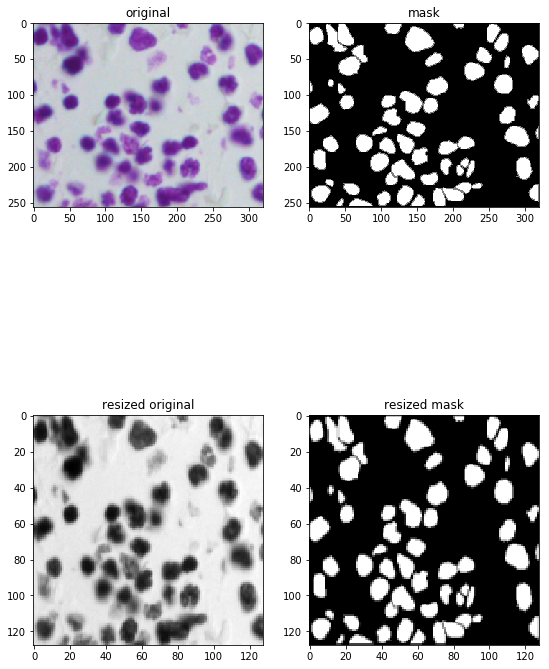

In [6]:

def evaluateImage(imageID, model=None):
    plt.figure(figsize=(14,14))

    img = getFileImage(fileIDs[imageID])

    print(img.shape)
    plt.subplot(231)
    plt.grid(False)
    plt.title('original')
    plt.imshow(img, cmap='gray')
    plt.subplot(234)
    plt.grid(False)
    plt.title('resized original')
    plt.imshow(imgResizeNormalizeAndGrayscale(img, (unetSize,unetSize)), cmap='gray')

    if model is not None:
        pred = model.predict(np.stack([imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize))])[:,:,:, newaxis])[0,:,:,0]
        print(pred.shape)
        plt.subplot(233)
        plt.grid(False)
        plt.title('prediction')
        plt.imshow(pred, cmap='gray')
        plt.subplot(236)
        plt.grid(False)
        plt.title('resized prediction')
        plt.imshow(imgResizeNormalizeAndGrayscale(pred, (unetSize,unetSize)), cmap='gray')
    
    img = getFileMasks(fileIDs[imageID])
    plt.subplot(232)
    plt.grid(False)
    plt.title('mask')
    plt.imshow(img, cmap='gray')
    plt.subplot(235)
    plt.grid(False)
    plt.title('resized mask')
    plt.imshow(imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize)), cmap='gray')
    


evaluateImage(40)
# evaluateImage(650, unetAE)

## Load files

In [97]:
if os.path.isfile('data/inputImgGrayscaleNormalized128Augm.npy'):
    inputImg = np.load('data/inputImgGrayscaleNormalized128Augm.npy')
    masks = np.load('data/masksGrayscaleNormalized128Augm.npy')
else:
    print('Missing files with image augmentation')
    inputImg = []
    masks = []
    for fileId in fileIDs:
        print('.', end ='')
        inputImg.append(imgResizeNormalizeAndGrayscale(getFileImage(fileId), (unetSize, unetSize)))
        masks.append(imgResizeNormalizeAndGrayscale(getFileMasks(fileId), (unetSize, unetSize)))
    inputImg = np.stack(inputImg)
    inputImg = inputImg[:,:,:, newaxis]
    masks = np.stack(masks)
    masks = masks[:,:,:, newaxis]
    np.save('data/masksGrayscaleNormalized128.npy', masks)
    np.save('data/inputImgGrayscaleNormalized128.npy', inputImg)
    
    
    
masks.shape
inputImg.shape

(2010, 128, 128, 1)

(2026, 128, 128, 1)

## Submit functionality

In [8]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
#     print(lab_img.shape, lab_img.max() )
#     print(lab_img)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)
        
        
        
def submit(testIDs, model):
    rles = []
    new_test_ids = []
    for fileID in testIDs:
        img = getFileImage(fileID, testDir)
        pred = model.predict(np.stack([imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize))])[:,:,:, newaxis])[0,:,:,0]
        pred = imgResizeNormalizeAndGrayscale(pred, (img.shape[1], img.shape[0]), False, False)
#         pred = np.round(imgResizeNormalizeAndGrayscale(pred, img.shape[:2], False, False) )
#         print('orig : ', img.shape, img.shape[:2], pred.shape)
        rle = list(prob_to_rles(pred))
        rles.extend(rle)
        new_test_ids.extend([fileID] * len(rle))
        # render prediction and original
        plt.figure()
        plt.subplot(121)
        plt.title('original')
        plt.imshow(img, cmap = 'gray')
        
        plt.title('prediction')
        plt.subplot(122)
        plt.imshow(pred, cmap = 'gray')
        
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

    return sub


# r = submit(testIDs, unetAE)
# r.head()
# submit(testIDs[:2], unetAE)

    
# cid = 1  
# print('test', inputImg[cid].shape)

# plt.imshow(inputImg[cid].reshape(inputImg[cid].shape[:2]))
# plt.figure()
# plt.imshow(masks[cid].reshape(masks[cid].shape[:2]))
# plt.show()

# rle = list(prob_to_rles(masks[cid]))
# print(len(rle))
# rle


## Image augmentation

In [94]:
def generateAugmentedImagesWithGenerator(imgs, folder, prefix, X_datagen, deleteFolder = False):
    
    if deleteFolder:
        shutil.rmtree(folder, ignore_errors=True) # remove folder
        os.makedirs(folder)

    seed = 42
    # render images to be augmented
#     for i, img in enumerate (imgs):
#         plt.figure()
#         plt.title('orig'+ str(i))
#         plt.imshow(img.reshape(img.shape[:2]));
    
    X_datagen.fit(imgs, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(inputImg[selIds], batch_size=len(selIds), shuffle=True, seed=seed)
    
    
    count = len(imgs)
#     print('count ', count)
    for X_batch in X_datagen.flow(imgs, batch_size=count, shuffle=True, seed=seed,
                                 save_to_dir=folder, save_prefix=prefix, save_format='png'):
#         print(X_batch.shape)
        for i in range(count):
            print('.', end ='')
#             print(X_batch[i].shape)
#             plt.figure()
#             plt.title('img '+ prefix + str(i))
#             plt.imshow(X_batch[i].reshape(128, 128))
        break
    
def generateAugmentedImages(imgs, folder, deleteFolder = False):
    X_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
    generateAugmentedImagesWithGenerator(imgs, folder, 'flipvertical', X_datagen, True)
    
    X_datagen = ImageDataGenerator(
        rotation_range=30.,
         width_shift_range=0.1,
         height_shift_range=0.1,
         shear_range=0.2,
         zoom_range=0.2,
         fill_mode='constant')
    generateAugmentedImagesWithGenerator(imgs, folder, 'rotation30', X_datagen, False)
    
# generateAugmentedImages(inputImg[:2], 'data/aug/img')

In [93]:
# generateAugmentedImages(masks, 'data/aug/masks', True)
generateAugmentedImages(inputImg, 'data/aug/img', True)

C:\ProgramData\Anaconda3\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (670, 128, 128, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 

(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 

(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 128, 1)
(128, 

In [95]:
def readImagesFromFolder(folder):
    imgs = []
    for img in listdir(folder):
        imgs.append(misc.imread(folder + img))
    imgs = np.stack(imgs)
    imgs = imgs[:,:,:, newaxis]
    return imgs

augmentedImg = readImagesFromFolder('data/aug/masks/')
augmentedMask = readImagesFromFolder('data/aug/img/')

augmentedImg.shape

inputImg = np.concatenate([augmentedImg,inputImg])
masks = np.concatenate([augmentedMask,masks])

inputImg.shape
masks.shape

flipvertical_0_6265.png
flipvertical_0_7569.png
flipvertical_100_2023.png
flipvertical_101_4966.png
flipvertical_102_5891.png
flipvertical_103_1080.png
flipvertical_104_5036.png
flipvertical_105_2563.png
flipvertical_106_3292.png
flipvertical_107_3586.png
flipvertical_108_4431.png
flipvertical_109_6841.png
flipvertical_10_7031.png
flipvertical_110_6643.png
flipvertical_111_3959.png
flipvertical_112_161.png
flipvertical_113_593.png
flipvertical_114_3390.png
flipvertical_115_5997.png
flipvertical_116_6354.png
flipvertical_117_663.png
flipvertical_118_9324.png
flipvertical_119_541.png
flipvertical_11_9759.png
flipvertical_120_5433.png
flipvertical_121_5093.png
flipvertical_122_867.png
flipvertical_123_8623.png
flipvertical_124_5469.png
flipvertical_125_6256.png
flipvertical_126_9398.png
flipvertical_127_1169.png
flipvertical_128_830.png
flipvertical_129_1651.png
flipvertical_12_5341.png
flipvertical_130_1136.png
flipvertical_131_2810.png
flipvertical_132_8667.png
flipvertical_133_9518.png

flipvertical_385_4578.png
flipvertical_386_9127.png
flipvertical_387_155.png
flipvertical_388_9262.png
flipvertical_389_1958.png
flipvertical_38_1724.png
flipvertical_390_6344.png
flipvertical_391_5779.png
flipvertical_392_6144.png
flipvertical_393_5063.png
flipvertical_394_3830.png
flipvertical_395_9046.png
flipvertical_396_8831.png
flipvertical_397_9794.png
flipvertical_398_6659.png
flipvertical_399_441.png
flipvertical_39_1376.png
flipvertical_3_5946.png
flipvertical_400_6040.png
flipvertical_401_5925.png
flipvertical_402_7358.png
flipvertical_403_4628.png
flipvertical_404_6370.png
flipvertical_405_9528.png
flipvertical_406_948.png
flipvertical_407_8179.png
flipvertical_408_6115.png
flipvertical_409_459.png
flipvertical_40_8706.png
flipvertical_410_7568.png
flipvertical_411_4646.png
flipvertical_412_392.png
flipvertical_413_1787.png
flipvertical_414_7374.png
flipvertical_415_1138.png
flipvertical_416_4741.png
flipvertical_417_7418.png
flipvertical_418_6362.png
flipvertical_419_2454.

flipvertical_68_9114.png
flipvertical_69_2159.png
flipvertical_6_7128.png
flipvertical_70_5132.png
flipvertical_71_2547.png
flipvertical_72_2979.png
flipvertical_73_2649.png
flipvertical_74_8505.png
flipvertical_75_3083.png
flipvertical_76_1037.png
flipvertical_77_3489.png
flipvertical_78_7604.png
flipvertical_79_7544.png
flipvertical_7_2461.png
flipvertical_80_2634.png
flipvertical_81_3983.png
flipvertical_82_1778.png
flipvertical_83_7902.png
flipvertical_84_5110.png
flipvertical_85_5189.png
flipvertical_86_7378.png
flipvertical_87_1124.png
flipvertical_88_697.png
flipvertical_89_2179.png
flipvertical_8_685.png
flipvertical_90_9596.png
flipvertical_91_5251.png
flipvertical_92_9235.png
flipvertical_93_1929.png
flipvertical_94_1013.png
flipvertical_95_226.png
flipvertical_96_7321.png
flipvertical_97_1828.png
flipvertical_98_7909.png
flipvertical_99_5588.png
flipvertical_9_2160.png
rotation30_0_4248.png
rotation30_0_6949.png
rotation30_100_4239.png
rotation30_101_4479.png
rotation30_102_

rotation30_374_5966.png
rotation30_375_7329.png
rotation30_376_6957.png
rotation30_377_9196.png
rotation30_378_5325.png
rotation30_379_8518.png
rotation30_37_1191.png
rotation30_380_4703.png
rotation30_381_2706.png
rotation30_382_1.png
rotation30_383_9225.png
rotation30_384_8316.png
rotation30_385_1104.png
rotation30_386_1861.png
rotation30_387_5269.png
rotation30_388_6943.png
rotation30_389_8320.png
rotation30_38_6297.png
rotation30_390_437.png
rotation30_391_4846.png
rotation30_392_3129.png
rotation30_393_9413.png
rotation30_394_8081.png
rotation30_395_901.png
rotation30_396_5398.png
rotation30_397_6678.png
rotation30_398_5529.png
rotation30_399_6604.png
rotation30_39_9603.png
rotation30_3_3553.png
rotation30_400_3918.png
rotation30_401_1067.png
rotation30_402_26.png
rotation30_403_6937.png
rotation30_404_7264.png
rotation30_405_7118.png
rotation30_406_547.png
rotation30_407_8758.png
rotation30_408_8895.png
rotation30_409_5338.png
rotation30_40_271.png
rotation30_410_3140.png
rotatio

rotation30_82_7601.png
rotation30_83_8979.png
rotation30_84_2795.png
rotation30_85_4588.png
rotation30_86_7297.png
rotation30_87_3084.png
rotation30_88_731.png
rotation30_89_1129.png
rotation30_8_4623.png
rotation30_90_1605.png
rotation30_91_2933.png
rotation30_92_9407.png
rotation30_93_8516.png
rotation30_94_5074.png
rotation30_95_7099.png
rotation30_96_1490.png
rotation30_97_893.png
rotation30_98_1390.png
rotation30_99_3389.png
rotation30_9_7349.png
rotation40_0_3385.png
rotation40_0_5191.png
rotation40_0_5578.png
rotation40_0_6265.png
rotation40_0_6949.png
rotation40_0_860.png
rotation40_1_2433.png
rotation40_1_466.png
rotation40_1_5390.png
rotation40_1_5734.png
rotation40_1_6396.png
rotation40_1_8322.png
flipvertical_0_7569.png
flipvertical_100_2023.png
flipvertical_101_4966.png
flipvertical_102_5891.png
flipvertical_103_1080.png
flipvertical_104_5036.png
flipvertical_105_2563.png
flipvertical_106_3292.png
flipvertical_107_3586.png
flipvertical_108_4431.png
flipvertical_109_6841.pn

flipvertical_361_4079.png
flipvertical_362_3348.png
flipvertical_363_6299.png
flipvertical_364_3831.png
flipvertical_365_9433.png
flipvertical_366_8381.png
flipvertical_367_9172.png
flipvertical_368_9890.png
flipvertical_369_1715.png
flipvertical_36_8652.png
flipvertical_370_6450.png
flipvertical_371_5433.png
flipvertical_372_1098.png
flipvertical_373_7096.png
flipvertical_374_2326.png
flipvertical_375_9087.png
flipvertical_376_6416.png
flipvertical_377_6980.png
flipvertical_378_6763.png
flipvertical_379_1674.png
flipvertical_37_3754.png
flipvertical_380_7950.png
flipvertical_381_9122.png
flipvertical_382_8915.png
flipvertical_383_6049.png
flipvertical_384_1089.png
flipvertical_385_4578.png
flipvertical_386_9127.png
flipvertical_387_155.png
flipvertical_388_9262.png
flipvertical_389_1958.png
flipvertical_38_1724.png
flipvertical_390_6344.png
flipvertical_391_5779.png
flipvertical_392_6144.png
flipvertical_393_5063.png
flipvertical_394_3830.png
flipvertical_395_9046.png
flipvertical_396

flipvertical_647_1141.png
flipvertical_648_1635.png
flipvertical_649_4000.png
flipvertical_64_3081.png
flipvertical_650_3361.png
flipvertical_651_6583.png
flipvertical_652_7835.png
flipvertical_653_6.png
flipvertical_654_3267.png
flipvertical_655_6564.png
flipvertical_656_9783.png
flipvertical_657_4928.png
flipvertical_658_2606.png
flipvertical_659_5906.png
flipvertical_65_1428.png
flipvertical_660_3273.png
flipvertical_661_7611.png
flipvertical_662_913.png
flipvertical_663_2011.png
flipvertical_664_1442.png
flipvertical_665_5546.png
flipvertical_666_1829.png
flipvertical_667_8767.png
flipvertical_668_6468.png
flipvertical_669_929.png
flipvertical_66_3967.png
flipvertical_67_6445.png
flipvertical_68_9114.png
flipvertical_69_2159.png
flipvertical_6_7128.png
flipvertical_70_5132.png
flipvertical_71_2547.png
flipvertical_72_2979.png
flipvertical_73_2649.png
flipvertical_74_8505.png
flipvertical_75_3083.png
flipvertical_76_1037.png
flipvertical_77_3489.png
flipvertical_78_7604.png
flipvert

rotation30_34_4476.png
rotation30_350_8082.png
rotation30_351_8107.png
rotation30_352_9697.png
rotation30_353_7970.png
rotation30_354_1916.png
rotation30_355_6996.png
rotation30_356_2757.png
rotation30_357_6464.png
rotation30_358_178.png
rotation30_359_9088.png
rotation30_35_478.png
rotation30_360_6362.png
rotation30_361_9743.png
rotation30_362_8683.png
rotation30_363_60.png
rotation30_364_9269.png
rotation30_365_6681.png
rotation30_366_2895.png
rotation30_367_585.png
rotation30_368_5823.png
rotation30_369_534.png
rotation30_36_515.png
rotation30_370_3462.png
rotation30_371_4011.png
rotation30_372_3398.png
rotation30_373_2155.png
rotation30_374_5966.png
rotation30_375_7329.png
rotation30_376_6957.png
rotation30_377_9196.png
rotation30_378_5325.png
rotation30_379_8518.png
rotation30_37_1191.png
rotation30_380_4703.png
rotation30_381_2706.png
rotation30_382_1.png
rotation30_383_9225.png
rotation30_384_8316.png
rotation30_385_1104.png
rotation30_386_1861.png
rotation30_387_5269.png
rotati

rotation30_660_5200.png
rotation30_661_8521.png
rotation30_662_865.png
rotation30_663_773.png
rotation30_664_4732.png
rotation30_665_3518.png
rotation30_666_6795.png
rotation30_667_6984.png
rotation30_668_2567.png
rotation30_669_1674.png
rotation30_66_3339.png
rotation30_67_548.png
rotation30_68_7675.png
rotation30_69_8264.png
rotation30_6_4818.png
rotation30_70_198.png
rotation30_71_9973.png
rotation30_72_571.png
rotation30_73_790.png
rotation30_74_9830.png
rotation30_75_1174.png
rotation30_76_178.png
rotation30_77_2244.png
rotation30_78_4086.png
rotation30_79_734.png
rotation30_7_7192.png
rotation30_80_6232.png
rotation30_81_798.png
rotation30_82_7601.png
rotation30_83_8979.png
rotation30_84_2795.png
rotation30_85_4588.png
rotation30_86_7297.png
rotation30_87_3084.png
rotation30_88_731.png
rotation30_89_1129.png
rotation30_8_4623.png
rotation30_90_1605.png
rotation30_91_2933.png
rotation30_92_9407.png
rotation30_93_8516.png
rotation30_94_5074.png
rotation30_95_7099.png
rotation30_96_

(1356, 128, 128, 1)

(2026, 128, 128, 1)

(2010, 128, 128, 1)

In [96]:
np.save('data/masksGrayscaleNormalized128Augm.npy', masks)
np.save('data/inputImgGrayscaleNormalized128Augm.npy', inputImg)

In [ ]:
# !rm data/*.npy

## U net

![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [12]:

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        
    def on_train_begin(self, logs={}):
        self.initVars()

    def on_epoch_end(self, epoch, logs={}):
        self.i += 1
        
        print('bi = ', i)
        clear_output(wait=True)
        print('i = ', i)
#         if self.i% 5 != 0:
#             return
        
        # make a prediction
        testIdx = random.randint(0, len(testIDs)-1)
        img = getFileImage(testIDs[testIdx], testDir)
        plt.figure(figsize=(10,8))
        plt.subplot(221)
        plt.grid(False)
        plt.title('original')
        plt.imshow(img, cmap='gray')
        
        pred = unetAE.predict(np.stack([imgResizeNormalizeAndGrayscale(img,(unetSize,unetSize))])[:,:,:, newaxis])[0,:,:,0]
        plt.subplot(222)
        plt.grid(False)
        plt.title('prediction')
        plt.imshow(pred, cmap='gray')
        
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
        self.x.append(self.i)
        
        plt.subplot(223)
        plt.plot(np.arange(len(self.losses)), self.losses, label="train loss")
        plt.plot(np.arange(len(self.losses)), self.val_losses, label="val loss")

        plt.legend()
        plt.show();

        
myPlotLosses = PlotLosses()
myPlotLosses.initVars();

In [16]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [17]:
imgsize = unetSize

def uconvx2(x, channels):
#     x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
#     x = Dropout(0.1) (x)
#     x = Conv2D(channels, (3,3), activation='elu', kernel_initializer='he_normal', padding='same')(x)
    x = Conv2D(channels, (3,3), activation='relu', padding='same')(x)
    x = Dropout(0.1) (x)
    x = Conv2D(channels, (3,3), activation='relu', padding='same')(x)
    return x

def uConvDown(x, channels):
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = uconvx2(x, channels)
    return x

def uConvUp(x, grey, channels):
    x = UpSampling2D((2, 2))(x)
    x = uconvx2(concatenate([x,grey]), channels)
    return x

inp = Input(shape=(imgsize,imgsize,1), name='input')

startChannel = 8
numChannels = 4
layer = []

layer.append(uconvx2(inp, startChannel))
for i in range(1, numChannels+1):
    layer.append(uConvDown(layer[-1],startChannel*(2**i)))

middle = layer[-1]

for i in range(numChannels+1,1,-1):
    layer.append(uConvUp(layer[-1], layer[i-2], startChannel*(2**i)))

out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(layer[-1])


mid = Model(inp, middle)
unetAE = Model(inp,out)
unetAE.compile(optimizer='adam', loss= bce_dice_loss,  metrics=[mean_iou])
# unetAE.compile(optimizer='adam', loss='binary_crossentropy')
# unetAE.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

unetAE.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
conv2d_39 (Conv2D)               (None, 128, 128, 8)   80          input[0][0]                      
____________________________________________________________________________________________________
dropout_19 (Dropout)             (None, 128, 128, 8)   0           conv2d_39[0][0]                  
____________________________________________________________________________________________________
conv2d_40 (Conv2D)               (None, 128, 128, 8)   584         dropout_19[0][0]                 
___________________________________________________________________________________________

i =  2


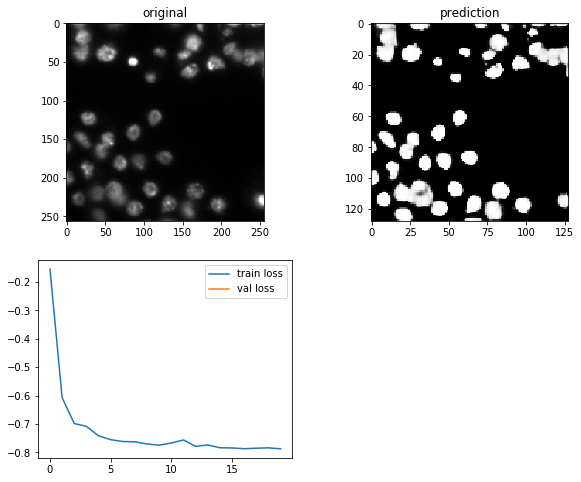

670/670 [==============================] - 3s - loss: -0.7879 - mean_iou: 0.7962     


In [18]:
batchSize = 4
# for i in range(0, len(inputImg), 20) :
#     x_train = inputImg[i: (i + 20)][:,:,:,:3]/255.0
#     y_train = masks[i: (i + 20)]/255.0
#     unetAE.fit(x_train, y_train,

earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('data/model1.h5', verbose=1, save_best_only=True)
unetAE.fit(inputImg, masks, epochs=20, batch_size=batchSize, shuffle=True, verbose=1 
           ,callbacks=[myPlotLosses, checkpointer]
#                 validation_data=(x_test, x_test),
              )

In [ ]:
unetAE.save('data/pc_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('data/pc_model.h5')

In [ ]:
evaluateImage(650, unetAE)

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


ImageId  \
0  17b9bf4356db24967c4677b8376ac38f826de73a88b93a...   
1  17b9bf4356db24967c4677b8376ac38f826de73a88b93a...   
2  17b9bf4356db24967c4677b8376ac38f826de73a88b93a...   
3  17b9bf4356db24967c4677b8376ac38f826de73a88b93a...   
4  17b9bf4356db24967c4677b8376ac38f826de73a88b93a...   

                                       EncodedPixels  
0  1 134 513 134 1025 134 1537 136 2049 137 2561 ...  
1  101377 3 101889 5 102401 6 102913 7 103425 7 1...  
2  169505 7 170015 10 170526 12 171038 13 171549 ...  
3  54868 11 55378 16 55891 15 56404 14 56916 13 5...  
4  130681 3 131191 7 131702 9 132213 10 132725 10...

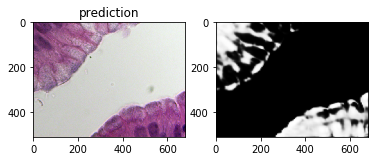

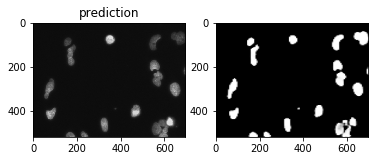

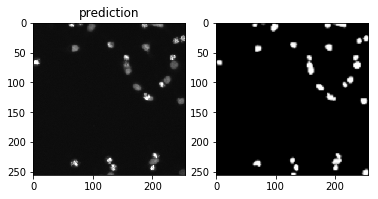

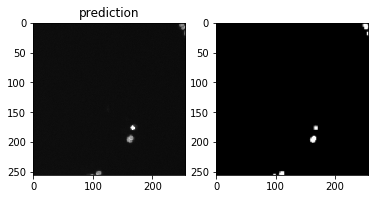

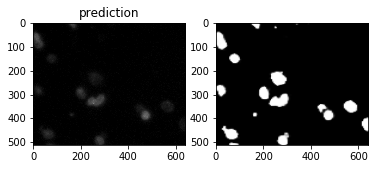

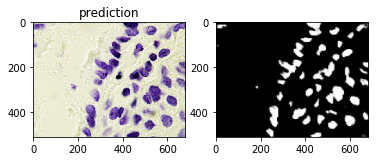

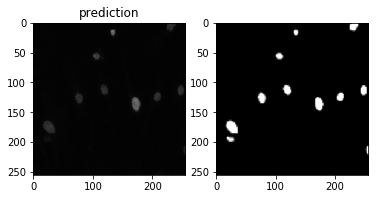

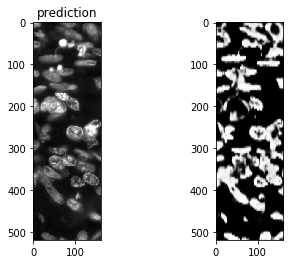

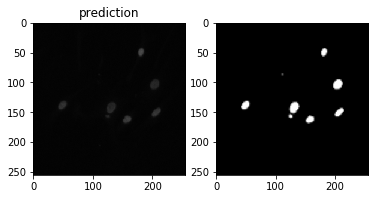

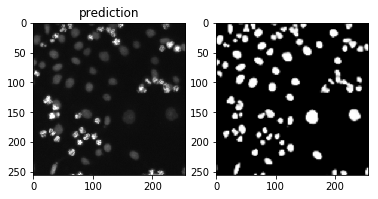

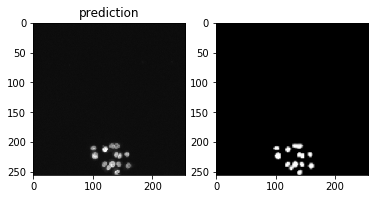

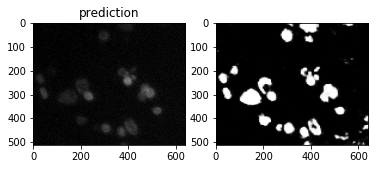

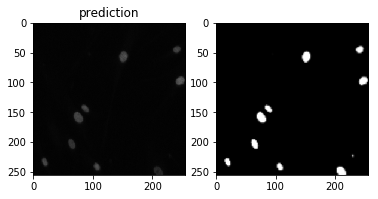

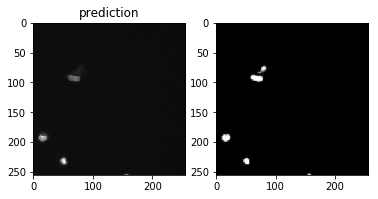

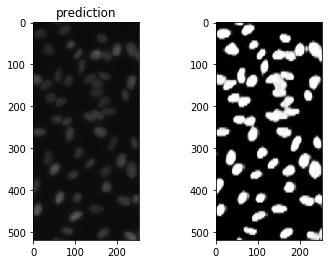

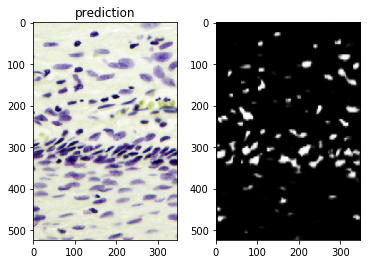

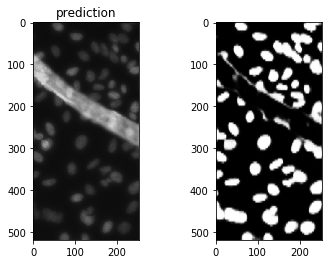

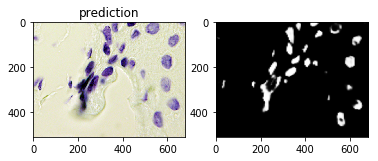

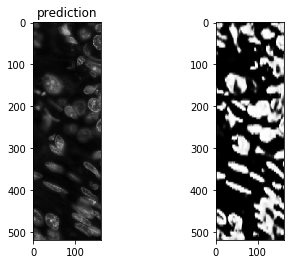

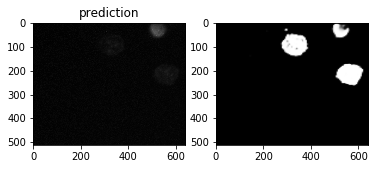

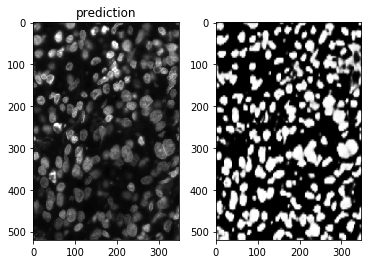

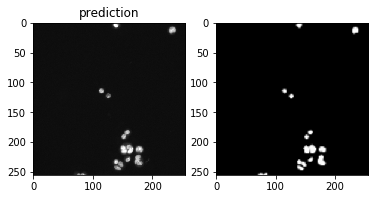

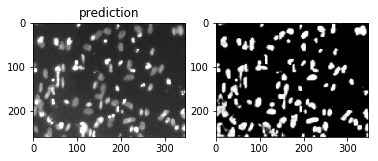

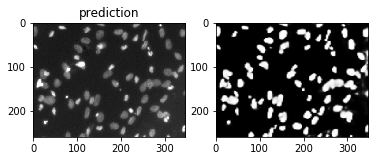

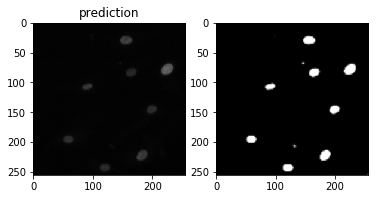

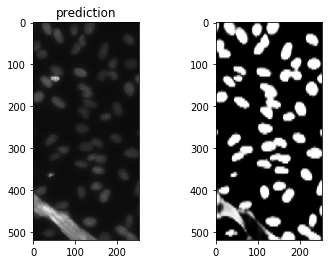

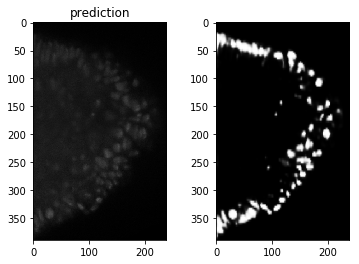

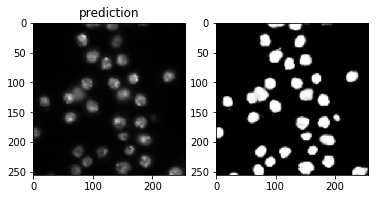

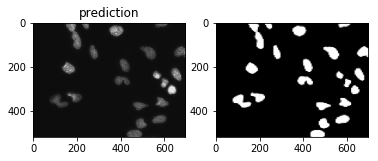

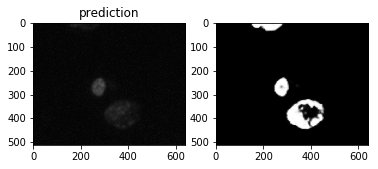

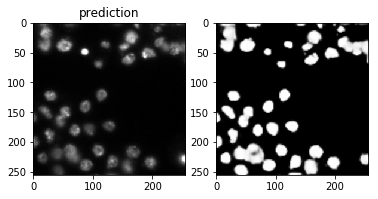

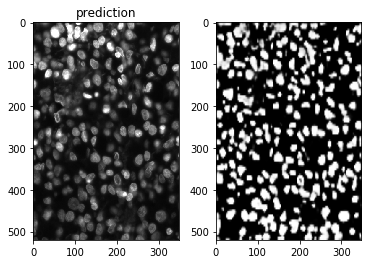

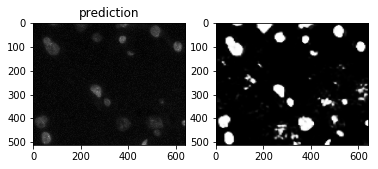

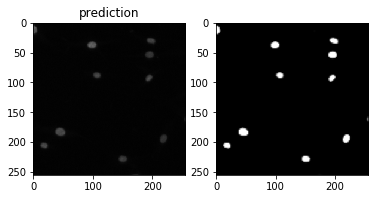

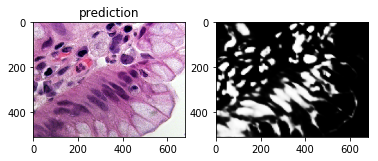

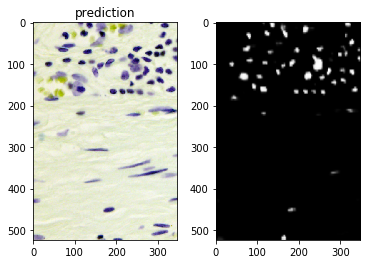

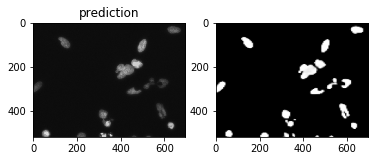

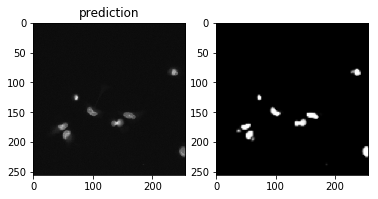

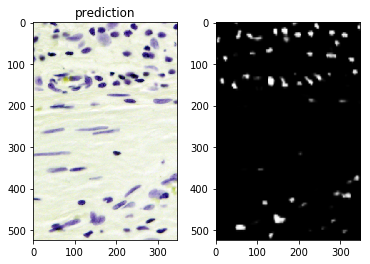

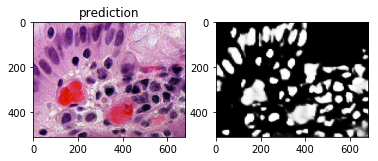

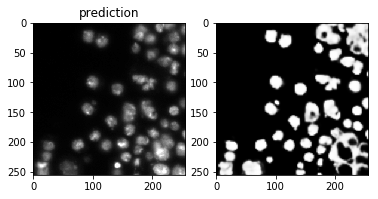

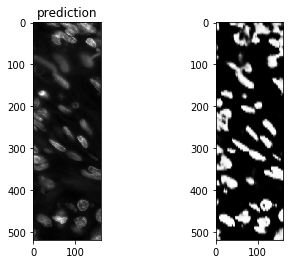

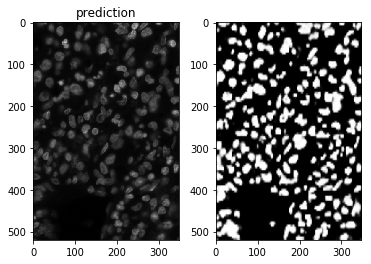

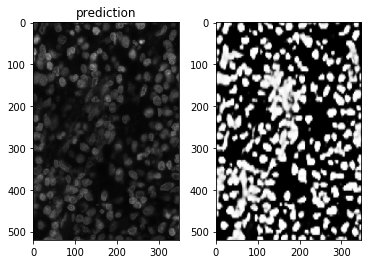

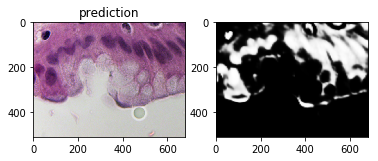

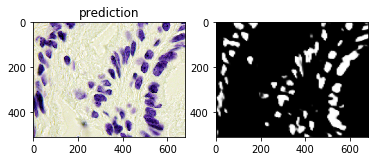

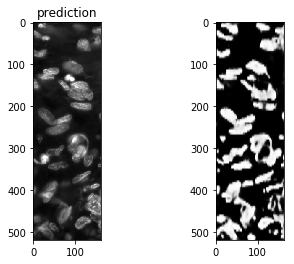

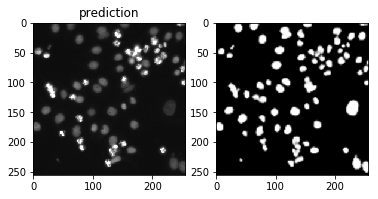

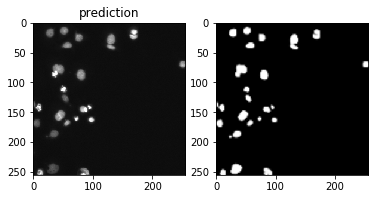

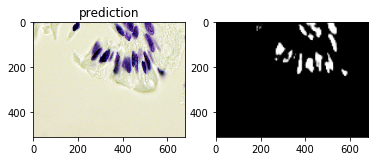

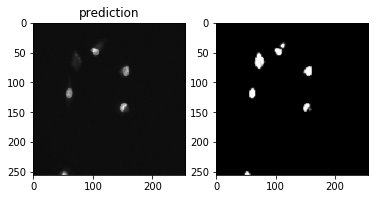

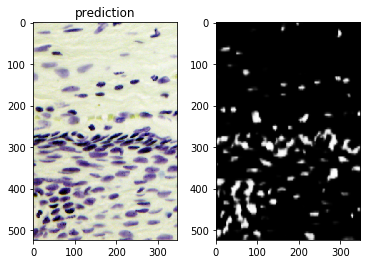

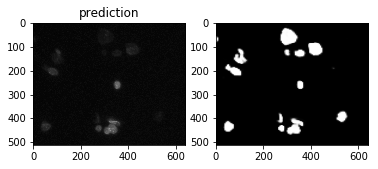

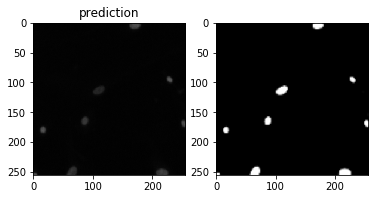

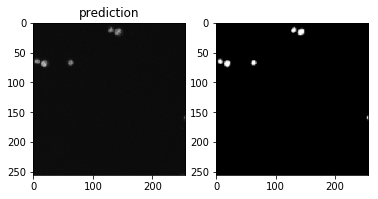

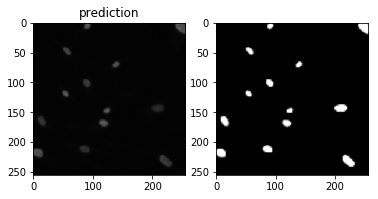

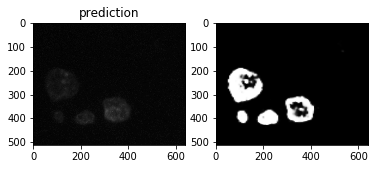

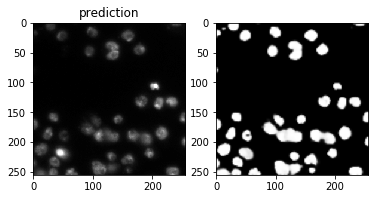

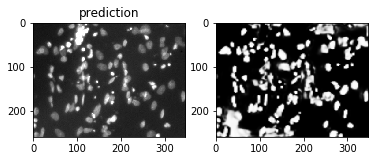

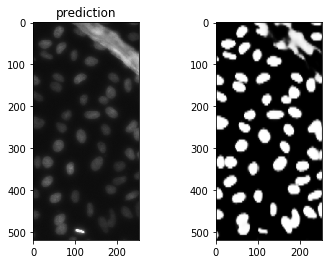

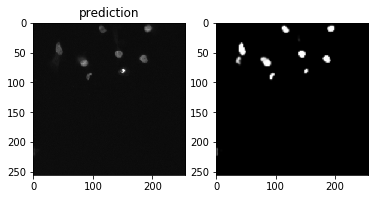

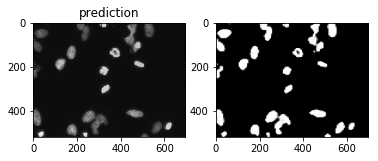

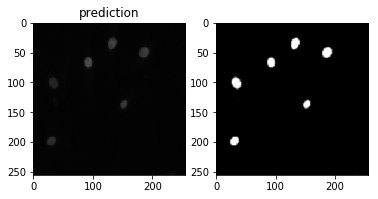

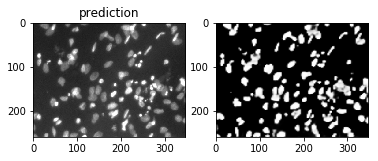

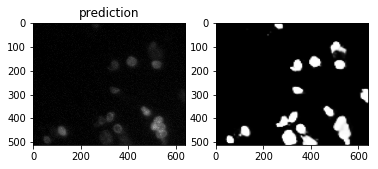

In [19]:
r = submit(testIDs, unetAE)
r.head()

In [20]:
# Write to file
filename = 'data/submission' + datetime.now().strftime('%Y-%m-%d_%H-%M')+ '.csv'
r.to_csv(filename, index=False)

In [ ]:
r.shape
len(testIDs)
# r.head()
len(r['ImageId'].unique())